In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [2]:
path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'

In [3]:
masks_name = os.listdir(os.path.join(path, 'mascara'))

In [4]:
pixels = 256

In [5]:
def read_img(img, folder):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [6]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [7]:
def binarize(img):
    img[img>0] = 1
    return img

In [8]:
masks = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    masks[i, ...] = binarize(read_img(masks_name[i], 'mascara'))

In [9]:
images = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    images[i, ...] = normalize(read_img(masks_name[i], 'images'))

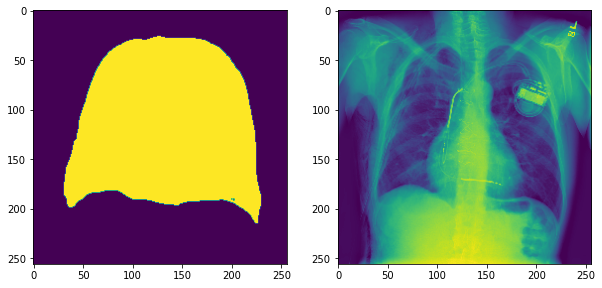

In [10]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(masks[r])
plt.subplot(1,2,2)
plt.imshow(images[r])
plt.show()

# U-Net

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [12]:
def double_conv_block(x, n_filters):
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    # Conv2D then eLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with eLU activation
    x = double_conv_block(x, n_filters)
    return x

In [24]:
def build_unet_model():
     # inputs
    inputs = layers.Input(shape=(pixels,pixels,1))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [25]:
unet_model = build_unet_model()

In [26]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_19[0][0]']              
                                )                                                             

                                                                                                  
 conv2d_33 (Conv2D)             (None, 128, 128, 12  295040      ['dropout_14[0][0]']             
                                8)                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 12  147584      ['conv2d_33[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 64  73792      ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [27]:
import datetime
log_dir = "/home/mr1142/Documents/Data/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
datagen.fit(images)

In [28]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [29]:
batch = 8
epoch = 20

In [ ]:
datagen.flow(images,masks, subset = 'training', batch_size = batch)

In [30]:
history = unet_model.fit(datagen.flow(images,masks, subset = 'training', batch_size = batch)
                        batch_size = batch,
                        epochs = epoch,
                        callbacks = tensorboard_callback,
                        shuffle = True,
                        validation_split = 0.2)

Epoch 1/20
8/8 [==============================] - 171s 22s/step - loss: 1.8235 - accuracy: 0.5169 - val_loss: 0.9405 - val_accuracy: 0.5283
Epoch 2/20
8/8 [==============================] - 174s 22s/step - loss: 0.8477 - accuracy: 0.5574 - val_loss: 0.6803 - val_accuracy: 0.6102
Epoch 3/20
8/8 [==============================] - 180s 23s/step - loss: 0.7173 - accuracy: 0.5901 - val_loss: 0.6297 - val_accuracy: 0.5927
Epoch 4/20
2/8 [======>.......................] - ETA: 1:55 - loss: 0.6588 - accuracy: 0.6201

KeyboardInterrupt: 

In [ ]:
epochs_range = range(epoch)
i = 0
for i in range(int(len(history.history.keys())/2)):
    key = list(history.history.keys())[i]
    
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.plot(epochs_range, history.history[key], label=key)
    plt.plot(epochs_range, history.history['val_' + key], label='val_' + key)
    plt.legend(loc='lower right')
    plt.title('Training and Validation')
plt.show()